In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

train_data = pd.read_csv('/content/drive/MyDrive/Colab Content/train_spam.csv')


#Знакомство с данными

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text_type          16278 non-null  object
 1   text               16278 non-null  object
 2   text_type_encoded  16278 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 381.6+ KB


In [11]:
train_data.groupby('text_type').describe()

text_type_encoded                                   
                      count mean  std  min  25%  50%  75%  max
text_type                                                     
ham                 11469.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
spam                 4809.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

Text(0, 0.5, 'Number of Data points')

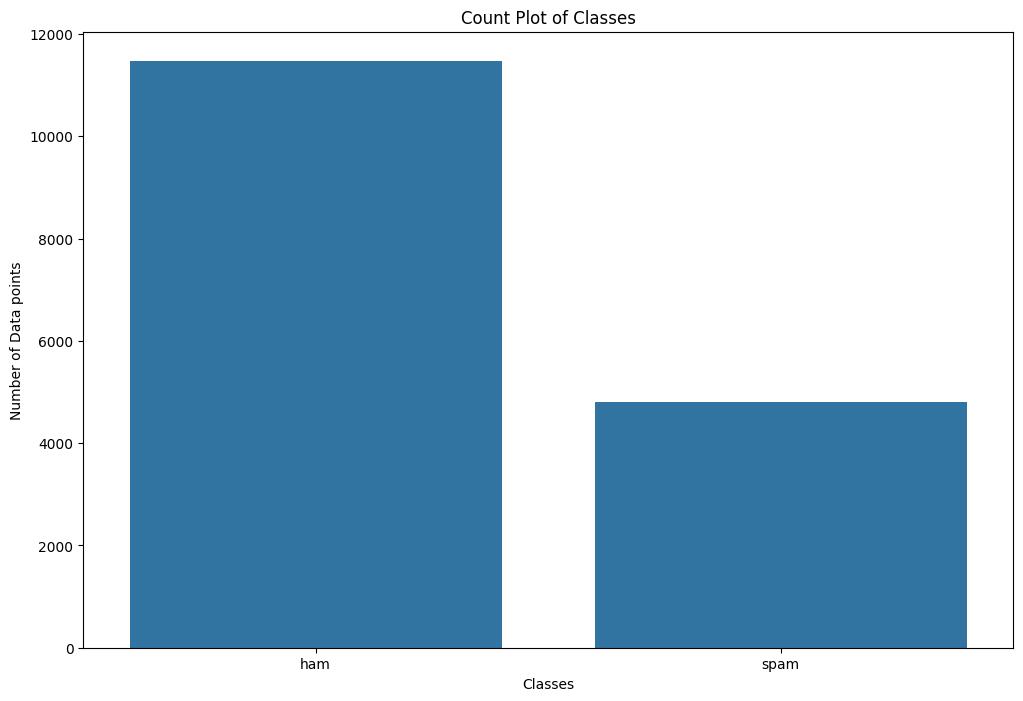

In [16]:
plt.figure(figsize=(12,8))
fg = sns.countplot(x= train_data["text_type"])
fg.set_title("Count Plot of Classes")
fg.set_xlabel("Classes")
fg.set_ylabel("Number of Data points")

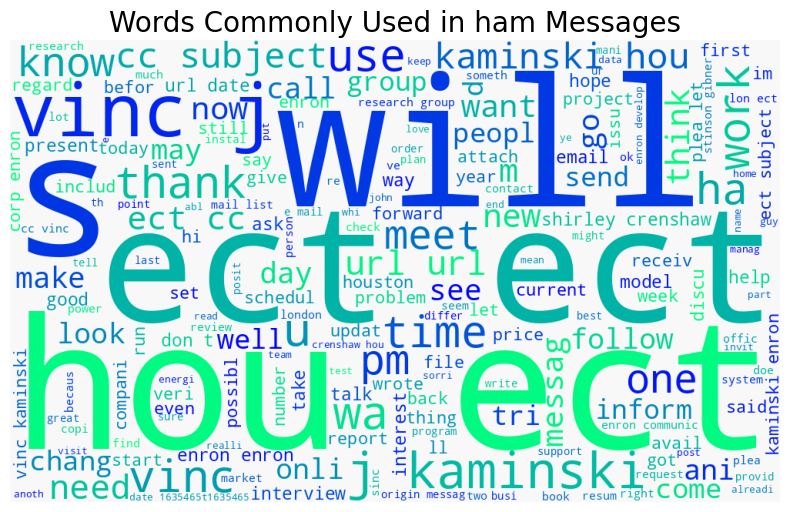

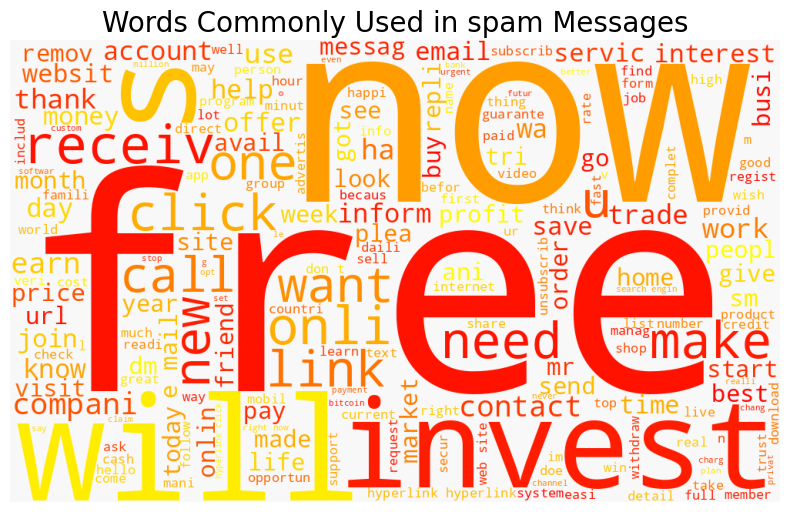

In [13]:
from wordcloud import WordCloud

for text_type, cmap in zip(["ham", "spam"], ["winter", "autumn"]):
    text = train_data.query("text_type == @text_type")["text"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in {text_type} Messages", size=20)
    plt.show()

#Обучение моделей

In [2]:
# Лемматизация и стемминг
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

train_data['text'] = train_data['text'].apply(preprocess_text)



In [3]:
le = LabelEncoder()
le.fit(train_data['text_type'])

train_data['text_type_encoded'] = le.transform(train_data['text_type'])
train_data.head()

,text_type,text,text_type_encoded
0,ham,make sure alex know his birthday is over in fi...,0
1,ham,a resum for john lavorato thank vinc i will ge...,0
2,spam,plzz visit my websit moviesgodml to get all mo...,1
3,spam,urgent your mobil number ha been award with a ...,1
4,ham,overview of hr associ analyst project per davi...,0


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
train, test = train_test_split(train_data, test_size=0.2, random_state=42)


In [6]:
# Преобразование текста в TF-IDF векторы
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_train = vectorizer.fit_transform(train['text'])
X_test = vectorizer.transform(test['text'])

y_train = train['text_type_encoded']
y_test = test['text_type_encoded']



In [7]:
classifiers = [
    ('Naive Bayes', MultinomialNB()),
    ('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('SVM', SVC(probability=True))
]

best_clf = None
best_roc_auc = 0

for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'{name} Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
    print(f'{name} Precision: {metrics.precision_score(y_test, y_pred)}')
    print(f'{name} Recall: {metrics.recall_score(y_test, y_pred)}')
    print(f'{name} F1 Score: {metrics.f1_score(y_test, y_pred)}')
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)
    print(f'{name} ROC AUC Score: {roc_auc}\n')
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_clf = clf


Naive Bayes Accuracy: 0.8682432432432432
Naive Bayes Precision: 0.9273648648648649
Naive Bayes Recall: 0.5871657754010695
Naive Bayes F1 Score: 0.7190569744597249
Naive Bayes ROC AUC Score: 0.9466913348708721

Random Forest Accuracy: 0.9348894348894349
Random Forest Precision: 0.9775429326287979
Random Forest Recall: 0.7914438502673797
Random Forest F1 Score: 0.8747044917257683
Random Forest ROC AUC Score: 0.9831081937298831

Logistic Regression Accuracy: 0.9216830466830467
Logistic Regression Precision: 0.9038004750593824
Logistic Regression Recall: 0.813903743315508
Logistic Regression F1 Score: 0.8564997186268992
Logistic Regression ROC AUC Score: 0.9766535261631188

SVM Accuracy: 0.9441031941031941
SVM Precision: 0.936268829663963
SVM Recall: 0.8641711229946524
SVM F1 Score: 0.8987764182424917
SVM ROC AUC Score: 0.9863008522511272



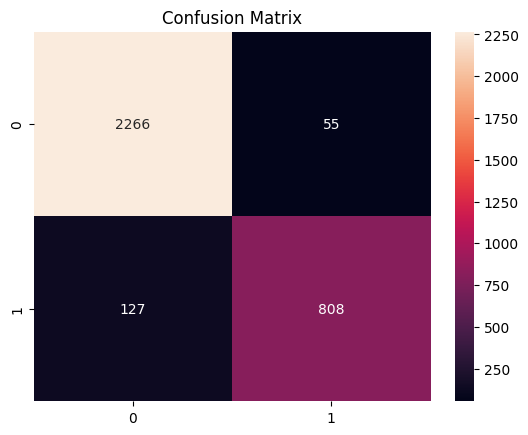

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2321
           1       0.94      0.86      0.90       935

    accuracy                           0.94      3256
   macro avg       0.94      0.92      0.93      3256
weighted avg       0.94      0.94      0.94      3256



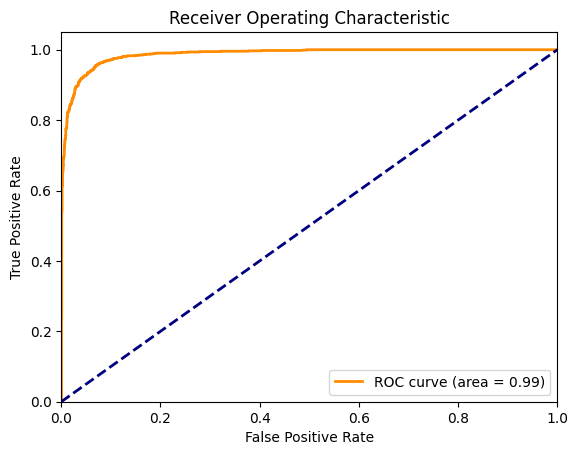

In [8]:
y_pred = best_clf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# ROC Curve
y_pred_proba = best_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Content/test_spam.csv')

test_data_copy = test_data.copy()
test_data_copy['text'] = test_data_copy['text'].apply(preprocess_text)

X_test_data = vectorizer.transform(test_data_copy['text'])

test_data['score'] = best_clf.predict_proba(X_test_data)[:, 1]
test_data = test_data[['score', 'text']]

test_data.to_csv('/content/drive/MyDrive/Colab Content/test/test_spam.csv', index=False)